<a href="https://colab.research.google.com/github/chambai/Deep_Learning_Course/blob/main/Week%201%20DL%202/HyperparameterTuningIris_Sln1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning Iris

Add hyperparemter tuning to the Iris DNN.
Adds hyperparameter tuning to the second layer of the Iris neural network.
Tries number of units from 10 to 200

In [8]:
# install the Keras-tuner library
!pip install keras-tuner

In [9]:
# import the library and refer to it as kt
import kerastuner as kt

In [10]:
import pandas as pd
from IPython.display import display
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# get the data
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Normalise the data
df_norm = normalize(df)

# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(df_norm, data.target, random_state=0)

# one-hot encode the data
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)


In [11]:
# build the model within a function
# Apply hyperparmeter tuning to the number of units in the second hidden layer in the model
def model_builder(hp):
  model = Sequential()
  model.add(tf.keras.layers.Dense(input_dim=4, units=10, activation='relu'))
  hp_units = hp.Int('units', min_value = 10, max_value = 200, step = 10)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))
  model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [12]:
# instatiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 125,
                     factor = 3,        # factor is a number that determines how many models are created to run in parallel whaen testing the hyperparameters
                     directory = 'my_dir',
                     project_name = 'intro_to_kt') 

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [13]:
# define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [14]:
import IPython
# run the hyperparameter search
tuner.search(x_train, y_train, epochs = 125, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print('best number of units: %s'%(best_hps.get('units')))

INFO:tensorflow:Oracle triggered exit
best number of units: 70


In [15]:
# retrain the model with the optimum hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs = 125, validation_data = (x_test, y_test))

Epoch 1/125
4/4 [==============================] - 1s 106ms/step - loss: 1.0963 - accuracy: 0.3298 - val_loss: 1.0729 - val_accuracy: 0.4211
Epoch 2/125
4/4 [==============================] - 0s 23ms/step - loss: 1.0932 - accuracy: 0.2850 - val_loss: 1.0738 - val_accuracy: 0.4211
Epoch 3/125
4/4 [==============================] - 0s 23ms/step - loss: 1.0821 - accuracy: 0.3823 - val_loss: 1.0734 - val_accuracy: 0.8684
Epoch 4/125
4/4 [==============================] - 0s 28ms/step - loss: 1.0739 - accuracy: 0.7768 - val_loss: 1.0719 - val_accuracy: 0.5789
Epoch 5/125
4/4 [==============================] - 0s 28ms/step - loss: 1.0652 - accuracy: 0.7171 - val_loss: 1.0709 - val_accuracy: 0.5789
Epoch 6/125
4/4 [==============================] - 0s 22ms/step - loss: 1.0569 - accuracy: 0.7057 - val_loss: 1.0688 - val_accuracy: 0.5789
Epoch 7/125
4/4 [==============================] - 0s 25ms/step - loss: 1.0533 - accuracy: 0.6807 - val_loss: 1.0658 - val_accuracy: 0.5789
Epoch 8/125
4/4 [==

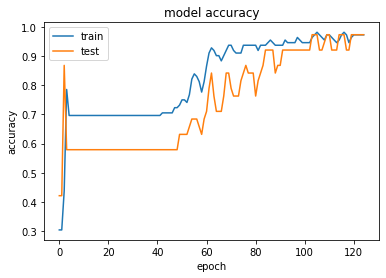

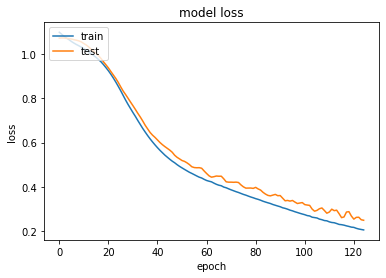

In [16]:
# summarize the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()